# Digit Recognizer

### Imports

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.models import load_model

import matplotlib.pyplot as plt

### Preparing Data

In [2]:
training_set = "./dataset/train.csv"
test_set = "./dataset/test.csv"

In [3]:
with open(training_set) as train:
    print(f"first line of train.csv \n{train.readline()}")
    print(f"second line of train.csv \n{train.readline()}")

first line of train.csv 
label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119

In [4]:
with open(test_set) as train:
    print(f"first line of test.csv \n{train.readline()}")
    print(f"second line of test.csv \n{train.readline()}")

first line of test.csv 
pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel1

In [5]:
def from_csv_nparray(csv_file, is_test=False):
    with open(csv_file) as file:
        reader = np.loadtxt(file, delimiter=',', skiprows=1)
        if is_test:
            images = reader.reshape((-1, 28, 28))
            return images
        labels = reader[:,0]
        images = reader[:, 1:].reshape((-1, 28, 28))

        return labels, images

In [6]:
Y, X = from_csv_nparray(training_set)

print(f"X shape : {X.shape}")
print(f"Y shape : {Y.shape}")

X shape : (42000, 28, 28)
Y shape : (42000,)


In [7]:
Y_one_hot = to_categorical(Y)
Y_one_hot

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, Y_one_hot, train_size=0.75, random_state=1, shuffle=True)

print(f"X train shape : {X_train.shape}")
print(f"Y train shape : {y_train.shape}")
print(f"X validation shape : {X_val.shape}")
print(f"Y validation shape : {y_val.shape}")

X train shape : (31500, 28, 28)
Y train shape : (31500, 10)
X validation shape : (10500, 28, 28)
Y validation shape : (10500, 10)


### Visualizing Data

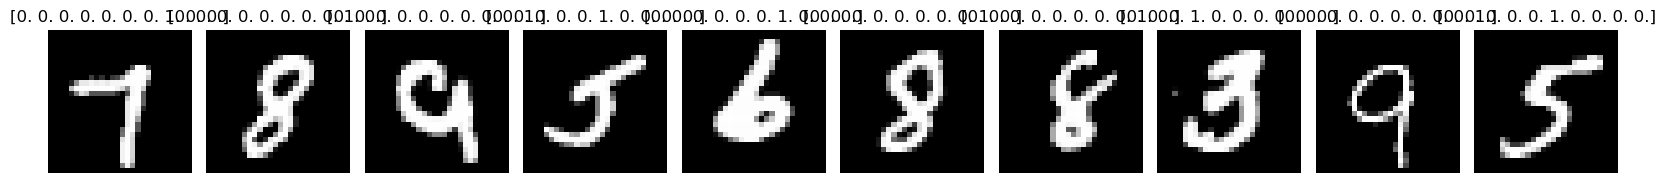

In [9]:
fig, axes = plt.subplots(1, 10, figsize=(16, 15))
axes = axes.flatten()

for i in range(10):
    img = X_train[i]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[i]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{y_train[i]}")
    ax.set_axis_off()

plt.tight_layout()
plt.show()

### Creating the image data generators

In [10]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.1,
                                   zoom_range=0.05,
                                   horizontal_flip=False,
                                   fill_mode='nearest')

train_generator = train_datagen.flow(x=X_train, y=y_train, batch_size=256)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow(x=X_val, y=y_val, batch_size=256)

### Creating the CNN

In [15]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
    BatchNormalization(axis=1),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    BatchNormalization(axis=1),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(axis=1),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Flatten(),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(10, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       112       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       56        
 hNormalization)                                                 
                                                        

### Defining a callback

In [13]:
checkpoint_path = 'checkpoint/best_model.h5'

_callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=7, mode='min', start_from_epoch=15)
]

### Training the model

In [16]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50,
                    callbacks=_callbacks)

Epoch 1/50
124/124 [==============================] - 95s 753ms/step - loss: 0.3687 - accuracy: 0.9127 - val_loss: 9.4137 - val_accuracy: 0.1121
Epoch 2/50
124/124 [==============================] - 92s 741ms/step - loss: 0.0906 - accuracy: 0.9743 - val_loss: 5.4899 - val_accuracy: 0.1121
Epoch 3/50
124/124 [==============================] - 94s 755ms/step - loss: 0.0629 - accuracy: 0.9807 - val_loss: 2.2536 - val_accuracy: 0.4042
Epoch 4/50
124/124 [==============================] - 91s 736ms/step - loss: 0.0462 - accuracy: 0.9858 - val_loss: 0.1266 - val_accuracy: 0.9590
Epoch 5/50
124/124 [==============================] - 89s 721ms/step - loss: 0.0429 - accuracy: 0.9870 - val_loss: 0.0611 - val_accuracy: 0.9831
Epoch 6/50
124/124 [==============================] - 88s 711ms/step - loss: 0.0406 - accuracy: 0.9878 - val_loss: 0.0612 - val_accuracy: 0.9841
Epoch 7/50
124/124 [==============================] - 91s 731ms/step - loss: 0.0320 - accuracy: 0.9896 - val_loss: 0.0490 - val_ac

### Plotting the training history

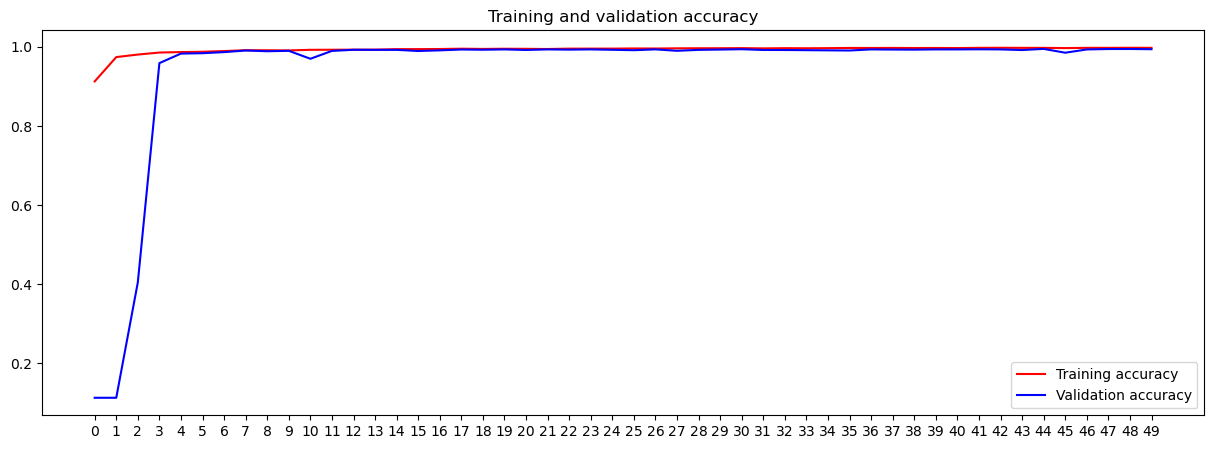

<Figure size 640x480 with 0 Axes>

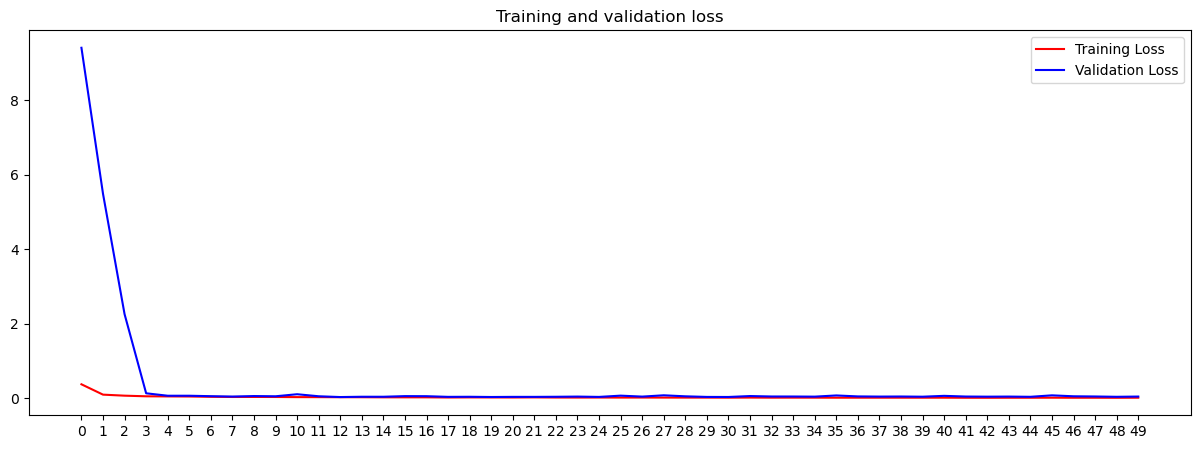

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = history.epoch

plt.figure(figsize=(15,5))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xticks(epochs)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.figure(figsize=(15,5))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting

In [25]:
model_best = load_model(checkpoint_path)

In [26]:
test_images = from_csv_nparray(test_set, True)
test_images = np.expand_dims(test_images, axis=-1)
predections = model_best.predict(test_images)
predections

875/875 [==============================] - 24s 27ms/step


array([[0.        , 0.        , 0.99999994, ..., 0.        , 0.        ,
        0.        ],
       [0.99999994, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.99999994],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.99999994],
       [0.        , 0.        , 0.99999994, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [27]:
predections = np.argmax(predections, axis=1)
predections

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

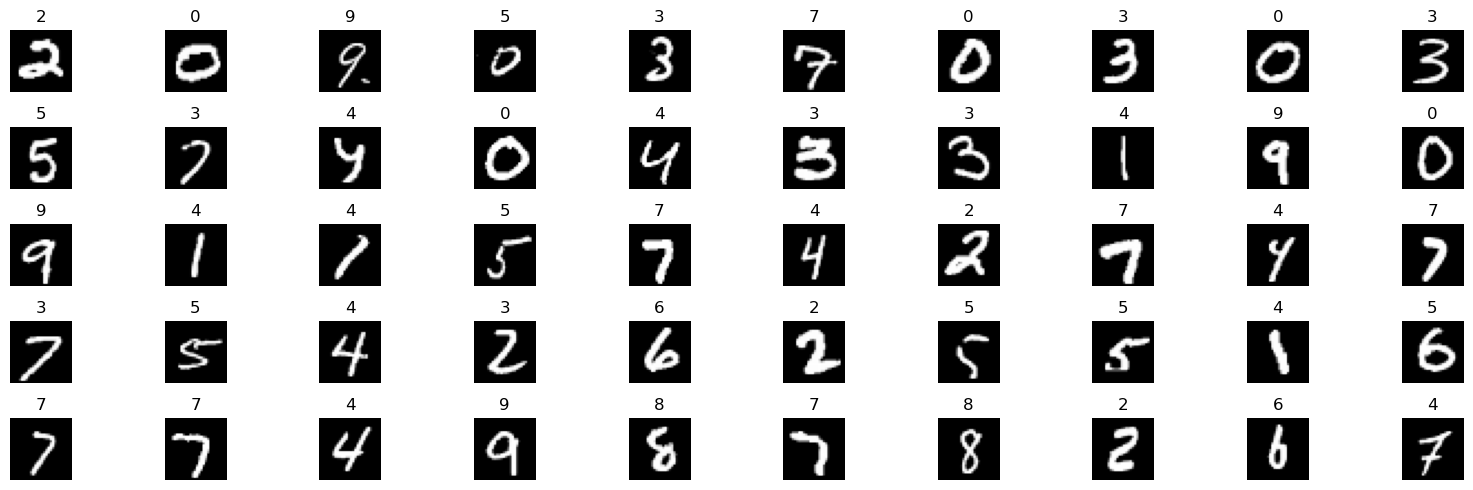

In [28]:
fig, axes = plt.subplots(5, 10, figsize=(16, 5))
axes = axes.flatten()

for i in range(50):
    img = test_images[i]
    img = array_to_img(img)
    ax = axes[i]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{predections[i]}")
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [29]:
submission = pd.DataFrame(data={'ImageId': np.arange(1, len(predections) + 1),'Label': predections})
submission.to_csv('./submissions/submission.csv', index=False)

### Visualizing intermediate representations

1/1 [==============================] - 0s 151ms/step


C:\Users\anaso\AppData\Local\Temp\ipykernel_18876\2483656505.py:24: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()
C:\Users\anaso\AppData\Local\Temp\ipykernel_18876\2483656505.py:27: RuntimeWarning: invalid value encountered in cast
  x  = np.clip(x, 0, 255).astype('uint8')


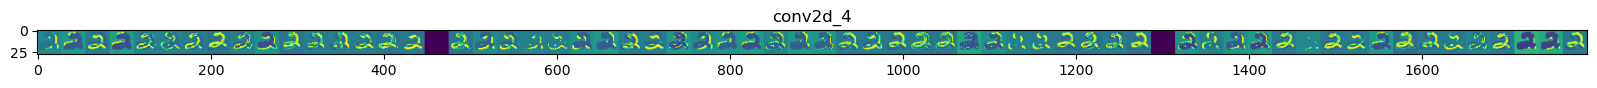

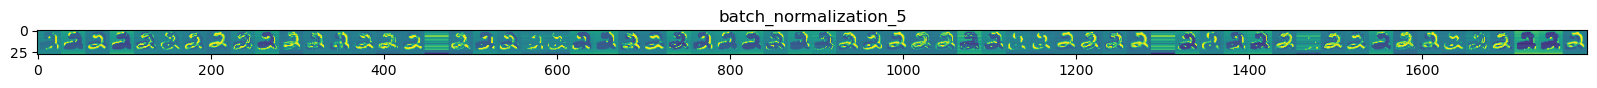

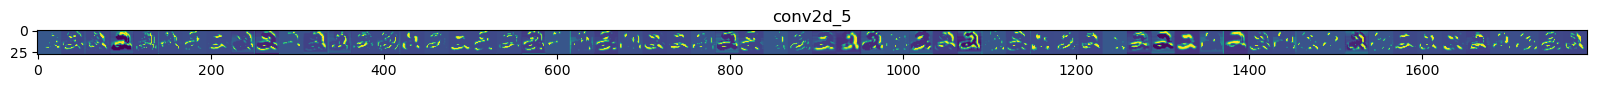

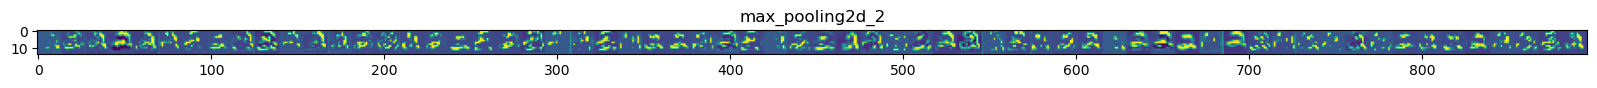

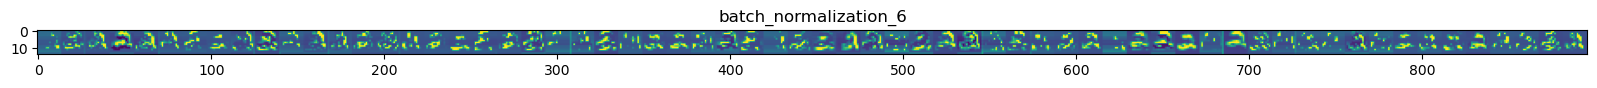

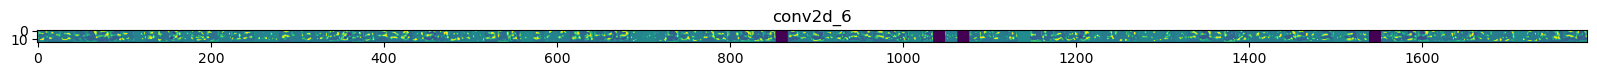

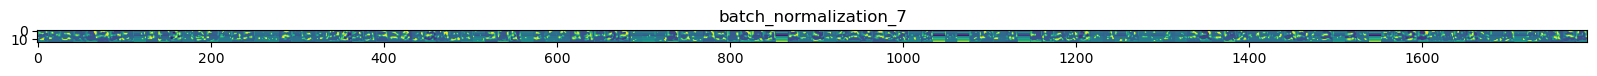

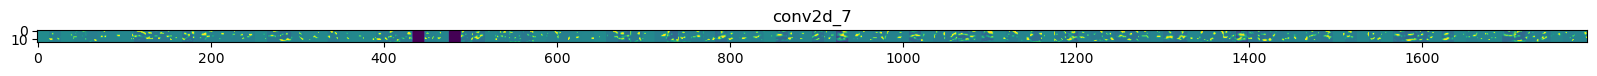

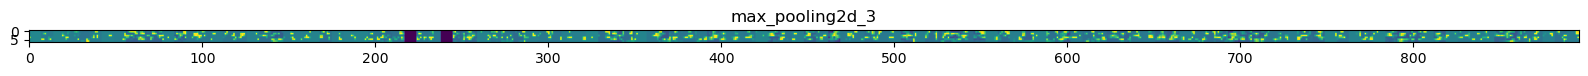

In [21]:
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

x   = test_images[0]
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 28, 28, 1)

x /= 255.0

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):

  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1]
    size       = feature_map.shape[ 1]

    display_grid = np.zeros((size, size * n_features))

    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )